In [5]:
import numpy as np
import librosa

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F

from torchvision.utils import make_grid  # |   Utility stuff for plotting
import matplotlib.pyplot as plt          # |  <- I use this one a lot for plotting, seaborn is a good alternative
from matplotlib.image import imread      # |  it reads images... (png -> usable input (like a numpy array for ex))
import os
import random
from tqdm import tqdm  # | This one is a cute one for making a loading bar, I like it and we'll use it here

In [6]:
#load the CREMA-D AudioWAV dataset and dataloader
def load_dataset(directory, batch_size):

    dataset = []
    emotion_to_number = {'NEU': 0, 'HAP': 1, 'SAD': 2, 'ANG': 3, 'DIS': 4, 'FEA': 5}
    max_len = 0
    
    for filename in os.listdir(directory):
        if(filename.endswith('.wav')):
            filepath  = os.path.join(directory, filename)
            emotion = filename.split('_')[2]
            emotion_no = emotion_to_number[emotion]
            emotion_label = torch.zeros(6)
            emotion_label[emotion_no] = 1
            audio_tensor, _ = librosa.load(filepath, sr=None)
            max_len = max(max_len, len(audio_tensor))
            audio_tensor = torch.tensor(audio_tensor, dtype=torch.float32)
            dataset.append([audio_tensor, emotion_label])

    dataset = [(torch.nn.functional.pad(audio_tensor, (0, max_len - audio_tensor.size(0))), label)
                      for audio_tensor, label in dataset]

    dataloader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
            
    return dataset, dataloader

In [7]:
crema_d_directory = "./AudioWAV"
dataset, dataloader = load_dataset(crema_d_directory, batch_size=32)

In [8]:
for inp, out in dataloader:
    print(len(inp[0]))
    print(out)
    break

80080
tensor([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        

In [9]:
class AudioCNN(nn.Module):

    def __init__(self, input_size, num_classes):
        super(AudioCNN, self).__init__()
        self.input_size = input_size
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Calculate the output size of the convolutional layers
        conv_output_size = (((input_size-2)//2) - 2)//2  # Considering two max pooling layers with kernel_size=2
        
        self.fc1 = nn.Linear(64 * conv_output_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


In [10]:
input_size = 80080
num_classes = 6  # 6 emotion classes

ex_audio, ex_label = dataset[random.randint(0,len(dataset))]

ex_audio = ex_audio.unsqueeze(0).unsqueeze(0)

test_model = AudioCNN(input_size=input_size, num_classes=6)
test_output = test_model(ex_audio)

print(test_output)
print(ex_label)
_,predicted = torch.max(test_output,0)
print(predicted)

tensor([[0.0000, 0.0016, 0.0255, 0.0000, 0.0000, 0.0265]],
       grad_fn=<ReluBackward0>)
tensor([0., 1., 0., 0., 0., 0.])
tensor([0, 0, 0, 0, 0, 0])


In [11]:
# training function here

def training(model, loss_function, optimizer, train_dataloader, n_epochs, update_interval):
    
    losses = []

    for n in range(n_epochs):
        for i, (audio, label) in enumerate(tqdm(iter(train_dataloader))):

            # TODO Complete the training loop using the instructions above
            # Hint: the above code essentially does one training step

            ##############################################################

            optimizer.zero_grad()
            audio = audio.unsqueeze(1)
            pred = model(audio)
            loss = loss_function(pred, label)
            loss.backward()
            optimizer.step()

            ##############################################################
        
            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for plotting -- please use "loss" as the name for your loss
        
    return model, losses

100%|██████████| 59/59 [11:33<00:00, 11.75s/it]


avg loss: 1.790666666666666


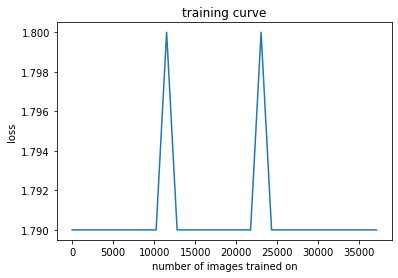

In [13]:
# Plug in your model, loss function, and optimizer 
# Try out different hyperparameters and different models to see how they perform
#train and tune

lr = 1e-4               # The size of the step taken when doing gradient descent
batch_size = 128       # The number of images being trained on at once
update_interval = 10   # The number of batches trained on before recording loss
n_epochs = 5            # The number of times we train through the entire dataset
input_size = 80080
num_classes = 6  # 6 emotion classes

train_dataset, train_dataloader = load_dataset(crema_d_directory, batch_size=batch_size)

model = AudioCNN(input_size=input_size, num_classes=num_classes)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

trained_model, losses = training(model, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)
 
print("avg loss:", sum(losses)/len(losses))

plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()